In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [7]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [8]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:25.0000 R:25.0000 rate:0.0500 gloss:1.7403 dlossA:1.9208 dlossQ:3.6086 exploreP:0.9975
Episode:1 meanR:19.5000 R:14.0000 rate:0.0280 gloss:1.7454 dlossA:1.9089 dlossQ:3.6243 exploreP:0.9961
Episode:2 meanR:18.3333 R:16.0000 rate:0.0320 gloss:1.7454 dlossA:1.9186 dlossQ:3.5642 exploreP:0.9946
Episode:3 meanR:19.7500 R:24.0000 rate:0.0480 gloss:1.7169 dlossA:1.8897 dlossQ:3.6345 exploreP:0.9922
Episode:4 meanR:21.4000 R:28.0000 rate:0.0560 gloss:1.7071 dlossA:1.8780 dlossQ:3.5193 exploreP:0.9895
Episode:5 meanR:21.3333 R:21.0000 rate:0.0420 gloss:1.6957 dlossA:1.8778 dlossQ:3.4810 exploreP:0.9874
Episode:6 meanR:20.2857 R:14.0000 rate:0.0280 gloss:1.7175 dlossA:1.8887 dlossQ:3.4768 exploreP:0.9860
Episode:7 meanR:19.5000 R:14.0000 rate:0.0280 gloss:1.6820 dlossA:1.8643 dlossQ:3.3989 exploreP:0.9847
Episode:8 meanR:21.3333 R:36.0000 rate:0.0720 gloss:1.6972 dlossA:1.8723 dlossQ:3.3822 exploreP:0.9812
Episode:9 meanR:20.8000 R:16.0000 rate:0.0320 gloss:1.6368 dlossA:1.8319 

Episode:79 meanR:24.6000 R:14.0000 rate:0.0280 gloss:0.4448 dlossA:1.2745 dlossQ:2.1534 exploreP:0.8231
Episode:80 meanR:24.5309 R:19.0000 rate:0.0380 gloss:0.4621 dlossA:1.2589 dlossQ:2.0616 exploreP:0.8216
Episode:81 meanR:24.3780 R:12.0000 rate:0.0240 gloss:0.7075 dlossA:1.4478 dlossQ:6.4344 exploreP:0.8206
Episode:82 meanR:24.2530 R:14.0000 rate:0.0280 gloss:0.4052 dlossA:1.2517 dlossQ:2.0081 exploreP:0.8195
Episode:83 meanR:24.2738 R:26.0000 rate:0.0520 gloss:0.1851 dlossA:1.2109 dlossQ:2.0168 exploreP:0.8174
Episode:84 meanR:24.2118 R:19.0000 rate:0.0380 gloss:0.2779 dlossA:1.2455 dlossQ:2.0191 exploreP:0.8159
Episode:85 meanR:24.0581 R:11.0000 rate:0.0220 gloss:0.1502 dlossA:1.2029 dlossQ:2.0073 exploreP:0.8150
Episode:86 meanR:24.1954 R:36.0000 rate:0.0720 gloss:-0.0057 dlossA:1.1744 dlossQ:2.0240 exploreP:0.8121
Episode:87 meanR:24.0455 R:11.0000 rate:0.0220 gloss:-0.2497 dlossA:1.1319 dlossQ:2.0073 exploreP:0.8112
Episode:88 meanR:23.9551 R:16.0000 rate:0.0320 gloss:-0.1783 d

Episode:156 meanR:20.4800 R:31.0000 rate:0.0620 gloss:-132.0238 dlossA:0.5290 dlossQ:57.3895 exploreP:0.7106
Episode:157 meanR:20.1000 R:15.0000 rate:0.0300 gloss:-145.7018 dlossA:0.5181 dlossQ:62.9343 exploreP:0.7095
Episode:158 meanR:20.0400 R:17.0000 rate:0.0340 gloss:-162.0535 dlossA:0.5354 dlossQ:69.0248 exploreP:0.7083
Episode:159 meanR:20.1600 R:57.0000 rate:0.1140 gloss:-178.0647 dlossA:0.5304 dlossQ:75.3571 exploreP:0.7044
Episode:160 meanR:19.9400 R:11.0000 rate:0.0220 gloss:-180.0876 dlossA:0.5033 dlossQ:74.6759 exploreP:0.7036
Episode:161 meanR:19.9900 R:16.0000 rate:0.0320 gloss:-175.0959 dlossA:0.5181 dlossQ:73.8919 exploreP:0.7025
Episode:162 meanR:20.1600 R:40.0000 rate:0.0800 gloss:-188.2585 dlossA:0.5218 dlossQ:77.9410 exploreP:0.6997
Episode:163 meanR:20.2800 R:42.0000 rate:0.0840 gloss:-202.4212 dlossA:0.5236 dlossQ:85.9781 exploreP:0.6968
Episode:164 meanR:20.2100 R:12.0000 rate:0.0240 gloss:-199.5491 dlossA:0.5299 dlossQ:83.9180 exploreP:0.6960
Episode:165 meanR:2

Episode:231 meanR:16.8300 R:18.0000 rate:0.0360 gloss:-1102.0596 dlossA:0.5460 dlossQ:415.8574 exploreP:0.6281
Episode:232 meanR:16.9400 R:26.0000 rate:0.0520 gloss:-1121.5533 dlossA:0.5203 dlossQ:414.4038 exploreP:0.6265
Episode:233 meanR:17.0000 R:29.0000 rate:0.0580 gloss:-1104.7615 dlossA:0.5019 dlossQ:414.4211 exploreP:0.6247
Episode:234 meanR:17.0100 R:16.0000 rate:0.0320 gloss:-1106.1061 dlossA:0.5536 dlossQ:419.8798 exploreP:0.6237
Episode:235 meanR:17.0200 R:10.0000 rate:0.0200 gloss:-1257.1995 dlossA:0.5271 dlossQ:464.0169 exploreP:0.6231
Episode:236 meanR:17.0300 R:10.0000 rate:0.0200 gloss:-1223.6005 dlossA:0.5272 dlossQ:459.0233 exploreP:0.6225
Episode:237 meanR:17.1100 R:18.0000 rate:0.0360 gloss:-1107.0120 dlossA:0.6451 dlossQ:431.9821 exploreP:0.6214
Episode:238 meanR:17.0900 R:10.0000 rate:0.0200 gloss:-1268.2531 dlossA:0.5160 dlossQ:452.1148 exploreP:0.6208
Episode:239 meanR:16.9600 R:16.0000 rate:0.0320 gloss:-1159.7856 dlossA:0.5192 dlossQ:427.0530 exploreP:0.6198
E

Episode:305 meanR:16.1800 R:14.0000 rate:0.0280 gloss:-4823.7886 dlossA:0.4990 dlossQ:1695.3066 exploreP:0.5593
Episode:306 meanR:15.9600 R:13.0000 rate:0.0260 gloss:-5197.1226 dlossA:0.5332 dlossQ:1774.2458 exploreP:0.5586
Episode:307 meanR:15.9900 R:12.0000 rate:0.0240 gloss:-5382.6255 dlossA:0.4818 dlossQ:1810.5114 exploreP:0.5579
Episode:308 meanR:15.9700 R:13.0000 rate:0.0260 gloss:-5010.9399 dlossA:0.4888 dlossQ:1736.3854 exploreP:0.5572
Episode:309 meanR:15.9600 R:14.0000 rate:0.0280 gloss:-5438.7476 dlossA:0.5462 dlossQ:1825.3811 exploreP:0.5564
Episode:310 meanR:15.8800 R:22.0000 rate:0.0440 gloss:-5556.5029 dlossA:0.5206 dlossQ:1882.0969 exploreP:0.5552
Episode:311 meanR:15.8400 R:11.0000 rate:0.0220 gloss:-5456.0483 dlossA:0.4910 dlossQ:1882.1360 exploreP:0.5546
Episode:312 meanR:15.7600 R:13.0000 rate:0.0260 gloss:-5460.9512 dlossA:0.4880 dlossQ:1919.5203 exploreP:0.5539
Episode:313 meanR:15.8300 R:19.0000 rate:0.0380 gloss:-5992.9673 dlossA:0.4794 dlossQ:2009.1680 exploreP

Episode:378 meanR:14.9500 R:15.0000 rate:0.0300 gloss:-16703.4844 dlossA:0.5366 dlossQ:5377.1455 exploreP:0.5032
Episode:379 meanR:15.0100 R:17.0000 rate:0.0340 gloss:-17927.7109 dlossA:0.5040 dlossQ:5770.6738 exploreP:0.5024
Episode:380 meanR:14.9400 R:10.0000 rate:0.0200 gloss:-17919.3301 dlossA:0.4676 dlossQ:5750.6562 exploreP:0.5019
Episode:381 meanR:14.6200 R:15.0000 rate:0.0300 gloss:-19814.2402 dlossA:0.4840 dlossQ:6147.0747 exploreP:0.5011
Episode:382 meanR:14.5600 R:10.0000 rate:0.0200 gloss:-19032.4668 dlossA:0.5057 dlossQ:6146.0146 exploreP:0.5006
Episode:383 meanR:14.5800 R:13.0000 rate:0.0260 gloss:-19415.7617 dlossA:0.5291 dlossQ:6311.3984 exploreP:0.5000
Episode:384 meanR:14.3700 R:11.0000 rate:0.0220 gloss:-17530.4609 dlossA:0.5525 dlossQ:5914.2588 exploreP:0.4995
Episode:385 meanR:14.4300 R:15.0000 rate:0.0300 gloss:-19092.2539 dlossA:0.4803 dlossQ:6101.1025 exploreP:0.4987
Episode:386 meanR:14.4900 R:19.0000 rate:0.0380 gloss:-18006.3906 dlossA:0.5406 dlossQ:6074.3887

Episode:451 meanR:14.2200 R:15.0000 rate:0.0300 gloss:-43129.5898 dlossA:0.5216 dlossQ:13940.6816 exploreP:0.4550
Episode:452 meanR:14.4000 R:31.0000 rate:0.0620 gloss:-47699.4023 dlossA:0.5095 dlossQ:14852.0508 exploreP:0.4536
Episode:453 meanR:14.3000 R:12.0000 rate:0.0240 gloss:-45256.7188 dlossA:0.5175 dlossQ:14833.5811 exploreP:0.4531
Episode:454 meanR:14.2500 R:11.0000 rate:0.0220 gloss:-50274.9414 dlossA:0.4903 dlossQ:15594.4775 exploreP:0.4526
Episode:455 meanR:14.2800 R:15.0000 rate:0.0300 gloss:-44662.6523 dlossA:0.5243 dlossQ:14690.1074 exploreP:0.4519
Episode:456 meanR:14.1500 R:11.0000 rate:0.0220 gloss:-48659.1367 dlossA:0.5143 dlossQ:15040.7930 exploreP:0.4514
Episode:457 meanR:14.1600 R:14.0000 rate:0.0280 gloss:-50923.8242 dlossA:0.4970 dlossQ:15403.2236 exploreP:0.4508
Episode:458 meanR:14.1500 R:11.0000 rate:0.0220 gloss:-46570.1250 dlossA:0.5136 dlossQ:15044.1846 exploreP:0.4503
Episode:459 meanR:14.1500 R:10.0000 rate:0.0200 gloss:-53082.5742 dlossA:0.5501 dlossQ:1

Episode:523 meanR:13.3800 R:11.0000 rate:0.0220 gloss:-100321.5234 dlossA:0.4996 dlossQ:33240.5273 exploreP:0.4150
Episode:524 meanR:13.3900 R:12.0000 rate:0.0240 gloss:-101783.9766 dlossA:0.4927 dlossQ:34691.3438 exploreP:0.4145
Episode:525 meanR:13.4900 R:21.0000 rate:0.0420 gloss:-112375.0703 dlossA:0.5143 dlossQ:36177.4688 exploreP:0.4136
Episode:526 meanR:13.4800 R:11.0000 rate:0.0220 gloss:-116329.7969 dlossA:0.5084 dlossQ:37370.1406 exploreP:0.4132
Episode:527 meanR:13.5700 R:18.0000 rate:0.0360 gloss:-111799.1797 dlossA:0.4955 dlossQ:35461.9102 exploreP:0.4125
Episode:528 meanR:13.5800 R:15.0000 rate:0.0300 gloss:-109248.0000 dlossA:0.4786 dlossQ:34479.3203 exploreP:0.4119
Episode:529 meanR:13.6200 R:16.0000 rate:0.0320 gloss:-115932.9531 dlossA:0.4806 dlossQ:36858.2656 exploreP:0.4112
Episode:530 meanR:13.5800 R:14.0000 rate:0.0280 gloss:-116150.3828 dlossA:0.4939 dlossQ:37680.9688 exploreP:0.4107
Episode:531 meanR:13.6000 R:13.0000 rate:0.0260 gloss:-123325.9141 dlossA:0.5160

Episode:595 meanR:12.5500 R:9.0000 rate:0.0180 gloss:-213352.7812 dlossA:0.5214 dlossQ:68834.6562 exploreP:0.3813
Episode:596 meanR:12.5300 R:10.0000 rate:0.0200 gloss:-222028.4219 dlossA:0.4863 dlossQ:70506.5156 exploreP:0.3809
Episode:597 meanR:12.5000 R:11.0000 rate:0.0220 gloss:-208246.7656 dlossA:0.5406 dlossQ:65513.0625 exploreP:0.3805
Episode:598 meanR:12.4500 R:8.0000 rate:0.0160 gloss:-212072.3750 dlossA:0.5063 dlossQ:66499.2031 exploreP:0.3802
Episode:599 meanR:12.4500 R:14.0000 rate:0.0280 gloss:-216765.9688 dlossA:0.4794 dlossQ:68212.0469 exploreP:0.3797
Episode:600 meanR:12.4700 R:11.0000 rate:0.0220 gloss:-200901.0000 dlossA:0.6895 dlossQ:74772.2344 exploreP:0.3793
Episode:601 meanR:12.4300 R:8.0000 rate:0.0160 gloss:-236273.5312 dlossA:0.5218 dlossQ:75763.3359 exploreP:0.3790
Episode:602 meanR:12.3700 R:11.0000 rate:0.0220 gloss:-227025.4375 dlossA:0.4954 dlossQ:72567.4453 exploreP:0.3786
Episode:603 meanR:12.3700 R:9.0000 rate:0.0180 gloss:-231017.7031 dlossA:0.5110 dlo

Episode:667 meanR:12.2400 R:17.0000 rate:0.0340 gloss:-403448.8125 dlossA:0.5235 dlossQ:131288.7031 exploreP:0.3493
Episode:668 meanR:12.2600 R:10.0000 rate:0.0200 gloss:-394263.0625 dlossA:0.5021 dlossQ:123326.8359 exploreP:0.3490
Episode:669 meanR:12.2300 R:11.0000 rate:0.0220 gloss:-403233.8125 dlossA:0.5101 dlossQ:125859.2812 exploreP:0.3486
Episode:670 meanR:12.3000 R:16.0000 rate:0.0320 gloss:-426580.1875 dlossA:0.5245 dlossQ:131255.4688 exploreP:0.3481
Episode:671 meanR:12.3100 R:11.0000 rate:0.0220 gloss:-361451.6250 dlossA:0.5306 dlossQ:132935.8906 exploreP:0.3477
Episode:672 meanR:12.2600 R:10.0000 rate:0.0200 gloss:-418454.6875 dlossA:0.4878 dlossQ:133108.3125 exploreP:0.3473
Episode:673 meanR:12.2000 R:10.0000 rate:0.0200 gloss:-401496.6875 dlossA:0.4943 dlossQ:130703.2734 exploreP:0.3470
Episode:674 meanR:12.1900 R:9.0000 rate:0.0180 gloss:-420083.1562 dlossA:0.5219 dlossQ:137697.8125 exploreP:0.3467
Episode:675 meanR:12.2000 R:11.0000 rate:0.0220 gloss:-414866.5938 dlossA

Episode:738 meanR:11.9700 R:10.0000 rate:0.0200 gloss:-726918.6250 dlossA:0.4794 dlossQ:227122.0938 exploreP:0.3223
Episode:739 meanR:11.8300 R:10.0000 rate:0.0200 gloss:-699750.0625 dlossA:0.4997 dlossQ:233398.8750 exploreP:0.3220
Episode:740 meanR:11.8000 R:8.0000 rate:0.0160 gloss:-699319.4375 dlossA:0.5113 dlossQ:211764.7344 exploreP:0.3218
Episode:741 meanR:11.8000 R:9.0000 rate:0.0180 gloss:-702760.1875 dlossA:0.4855 dlossQ:230460.3594 exploreP:0.3215
Episode:742 meanR:11.8200 R:13.0000 rate:0.0260 gloss:-720676.4375 dlossA:0.5093 dlossQ:227267.0938 exploreP:0.3211
Episode:743 meanR:11.8400 R:14.0000 rate:0.0280 gloss:-734326.1875 dlossA:0.4663 dlossQ:226899.5938 exploreP:0.3206
Episode:744 meanR:11.8300 R:12.0000 rate:0.0240 gloss:-677794.0000 dlossA:0.4895 dlossQ:223016.3594 exploreP:0.3203
Episode:745 meanR:11.8300 R:12.0000 rate:0.0240 gloss:-736836.7500 dlossA:0.5266 dlossQ:231439.2969 exploreP:0.3199
Episode:746 meanR:11.8500 R:12.0000 rate:0.0240 gloss:-697890.6875 dlossA:

Episode:809 meanR:11.9100 R:12.0000 rate:0.0240 gloss:-1123796.2500 dlossA:0.5575 dlossQ:370245.8750 exploreP:0.2968
Episode:810 meanR:11.9500 R:15.0000 rate:0.0300 gloss:-1189696.3750 dlossA:0.4749 dlossQ:376885.3438 exploreP:0.2964
Episode:811 meanR:11.9400 R:10.0000 rate:0.0200 gloss:-1175731.1250 dlossA:0.4935 dlossQ:345089.4375 exploreP:0.2961
Episode:812 meanR:11.9500 R:10.0000 rate:0.0200 gloss:-1146079.8750 dlossA:0.4527 dlossQ:368007.3750 exploreP:0.2958
Episode:813 meanR:11.9600 R:10.0000 rate:0.0200 gloss:-1183919.0000 dlossA:0.4477 dlossQ:397410.2500 exploreP:0.2955
Episode:814 meanR:12.0100 R:16.0000 rate:0.0320 gloss:-1195344.5000 dlossA:0.4949 dlossQ:382101.8750 exploreP:0.2951
Episode:815 meanR:12.0400 R:12.0000 rate:0.0240 gloss:-1258894.2500 dlossA:0.4701 dlossQ:405910.4688 exploreP:0.2947
Episode:816 meanR:12.0400 R:9.0000 rate:0.0180 gloss:-1219558.3750 dlossA:0.4730 dlossQ:396246.6250 exploreP:0.2945
Episode:817 meanR:12.1000 R:16.0000 rate:0.0320 gloss:-1221619.50

Episode:880 meanR:11.6600 R:10.0000 rate:0.0200 gloss:-1819257.6250 dlossA:0.5052 dlossQ:559312.7500 exploreP:0.2744
Episode:881 meanR:11.6300 R:10.0000 rate:0.0200 gloss:-1856757.3750 dlossA:0.5536 dlossQ:677395.8750 exploreP:0.2741
Episode:882 meanR:11.6300 R:9.0000 rate:0.0180 gloss:-1948000.0000 dlossA:0.5035 dlossQ:588842.2500 exploreP:0.2739
Episode:883 meanR:11.6500 R:11.0000 rate:0.0220 gloss:-1806076.8750 dlossA:0.4913 dlossQ:597016.4375 exploreP:0.2736
Episode:884 meanR:11.6000 R:9.0000 rate:0.0180 gloss:-1962569.7500 dlossA:0.4740 dlossQ:613812.6875 exploreP:0.2734
Episode:885 meanR:11.6300 R:12.0000 rate:0.0240 gloss:-1990664.0000 dlossA:0.4497 dlossQ:632073.4375 exploreP:0.2731
Episode:886 meanR:11.6300 R:12.0000 rate:0.0240 gloss:-1907850.5000 dlossA:0.5040 dlossQ:600316.1250 exploreP:0.2728
Episode:887 meanR:11.5700 R:12.0000 rate:0.0240 gloss:-1734185.0000 dlossA:0.4808 dlossQ:618064.6875 exploreP:0.2724
Episode:888 meanR:11.5300 R:9.0000 rate:0.0180 gloss:-2039184.2500

Episode:951 meanR:10.9700 R:8.0000 rate:0.0160 gloss:-2872891.0000 dlossA:0.4563 dlossQ:1032977.0625 exploreP:0.2547
Episode:952 meanR:10.9700 R:10.0000 rate:0.0200 gloss:-2977106.2500 dlossA:0.4709 dlossQ:959404.3125 exploreP:0.2544
Episode:953 meanR:10.9700 R:12.0000 rate:0.0240 gloss:-2703031.0000 dlossA:0.4945 dlossQ:955391.2500 exploreP:0.2542
Episode:954 meanR:10.9400 R:10.0000 rate:0.0200 gloss:-2822155.5000 dlossA:0.4362 dlossQ:956298.1250 exploreP:0.2539
Episode:955 meanR:10.9200 R:8.0000 rate:0.0160 gloss:-3138382.0000 dlossA:0.5135 dlossQ:1004907.1875 exploreP:0.2537
Episode:956 meanR:10.9200 R:9.0000 rate:0.0180 gloss:-2904030.7500 dlossA:0.4783 dlossQ:1031487.5625 exploreP:0.2535
Episode:957 meanR:10.9700 R:16.0000 rate:0.0320 gloss:-2930818.5000 dlossA:0.5150 dlossQ:1000508.5000 exploreP:0.2531
Episode:958 meanR:10.9800 R:10.0000 rate:0.0200 gloss:-2719733.5000 dlossA:0.4635 dlossQ:1023356.6250 exploreP:0.2529
Episode:959 meanR:10.9900 R:11.0000 rate:0.0220 gloss:-3090617

Episode:1021 meanR:10.8500 R:12.0000 rate:0.0240 gloss:-3659518.0000 dlossA:0.4645 dlossQ:1398045.2500 exploreP:0.2369
Episode:1022 meanR:10.8500 R:10.0000 rate:0.0200 gloss:-4258011.0000 dlossA:0.5310 dlossQ:1333652.2500 exploreP:0.2366
Episode:1023 meanR:10.8500 R:12.0000 rate:0.0240 gloss:-4458868.0000 dlossA:0.4894 dlossQ:1446561.3750 exploreP:0.2364
Episode:1024 meanR:10.8600 R:12.0000 rate:0.0240 gloss:-4325482.0000 dlossA:0.4992 dlossQ:1471505.8750 exploreP:0.2361
Episode:1025 meanR:10.8300 R:9.0000 rate:0.0180 gloss:-4239763.0000 dlossA:0.5110 dlossQ:1455580.5000 exploreP:0.2359
Episode:1026 meanR:10.8100 R:8.0000 rate:0.0160 gloss:-4157378.5000 dlossA:0.5283 dlossQ:1432766.2500 exploreP:0.2357
Episode:1027 meanR:10.7600 R:11.0000 rate:0.0220 gloss:-4313279.5000 dlossA:0.4909 dlossQ:1454249.1250 exploreP:0.2355
Episode:1028 meanR:10.7800 R:12.0000 rate:0.0240 gloss:-4458829.5000 dlossA:0.4798 dlossQ:1453989.5000 exploreP:0.2352
Episode:1029 meanR:10.8200 R:14.0000 rate:0.0280 g

Episode:1090 meanR:11.0000 R:11.0000 rate:0.0220 gloss:-5750874.5000 dlossA:0.4876 dlossQ:1882373.2500 exploreP:0.2199
Episode:1091 meanR:10.9800 R:9.0000 rate:0.0180 gloss:-5561542.0000 dlossA:0.4717 dlossQ:1874888.0000 exploreP:0.2197
Episode:1092 meanR:10.9800 R:9.0000 rate:0.0180 gloss:-5784006.5000 dlossA:0.5241 dlossQ:1855953.7500 exploreP:0.2196
Episode:1093 meanR:10.9800 R:13.0000 rate:0.0260 gloss:-6249106.5000 dlossA:0.5221 dlossQ:1872926.2500 exploreP:0.2193
Episode:1094 meanR:10.9400 R:10.0000 rate:0.0200 gloss:-6122479.0000 dlossA:0.5293 dlossQ:1911378.6250 exploreP:0.2191
Episode:1095 meanR:10.9300 R:9.0000 rate:0.0180 gloss:-5708255.0000 dlossA:0.5557 dlossQ:1729046.2500 exploreP:0.2189
Episode:1096 meanR:10.9500 R:12.0000 rate:0.0240 gloss:-5898214.5000 dlossA:0.4454 dlossQ:2128339.0000 exploreP:0.2186
Episode:1097 meanR:10.9700 R:14.0000 rate:0.0280 gloss:-6424020.5000 dlossA:0.4928 dlossQ:1947010.0000 exploreP:0.2183
Episode:1098 meanR:10.9700 R:11.0000 rate:0.0220 gl

Episode:1160 meanR:10.6700 R:11.0000 rate:0.0220 gloss:-8703784.0000 dlossA:0.4763 dlossQ:2846055.7500 exploreP:0.2048
Episode:1161 meanR:10.6600 R:10.0000 rate:0.0200 gloss:-8988661.0000 dlossA:0.5066 dlossQ:3054783.2500 exploreP:0.2047
Episode:1162 meanR:10.6900 R:14.0000 rate:0.0280 gloss:-8331519.5000 dlossA:0.4760 dlossQ:2876119.5000 exploreP:0.2044
Episode:1163 meanR:10.7000 R:12.0000 rate:0.0240 gloss:-8710426.0000 dlossA:0.4747 dlossQ:2957150.0000 exploreP:0.2041
Episode:1164 meanR:10.6900 R:9.0000 rate:0.0180 gloss:-9249363.0000 dlossA:0.5133 dlossQ:2787305.0000 exploreP:0.2040
Episode:1165 meanR:10.6800 R:10.0000 rate:0.0200 gloss:-9973885.0000 dlossA:0.5669 dlossQ:3008220.7500 exploreP:0.2038
Episode:1166 meanR:10.6900 R:11.0000 rate:0.0220 gloss:-7952515.0000 dlossA:0.4593 dlossQ:3178219.0000 exploreP:0.2036
Episode:1167 meanR:10.6900 R:12.0000 rate:0.0240 gloss:-8722365.0000 dlossA:0.5161 dlossQ:2706385.5000 exploreP:0.2033
Episode:1168 meanR:10.6800 R:9.0000 rate:0.0180 g

Episode:1229 meanR:10.3900 R:11.0000 rate:0.0220 gloss:-12313517.0000 dlossA:0.5304 dlossQ:3650305.5000 exploreP:0.1916
Episode:1230 meanR:10.4000 R:11.0000 rate:0.0220 gloss:-11488885.0000 dlossA:0.4986 dlossQ:3532415.2500 exploreP:0.1914
Episode:1231 meanR:10.3900 R:9.0000 rate:0.0180 gloss:-12162119.0000 dlossA:0.4754 dlossQ:3748753.0000 exploreP:0.1912
Episode:1232 meanR:10.4000 R:11.0000 rate:0.0220 gloss:-11628917.0000 dlossA:0.5164 dlossQ:3718339.7500 exploreP:0.1910
Episode:1233 meanR:10.4200 R:11.0000 rate:0.0220 gloss:-11074703.0000 dlossA:0.4543 dlossQ:3875996.7500 exploreP:0.1908
Episode:1234 meanR:10.3500 R:9.0000 rate:0.0180 gloss:-11907054.0000 dlossA:0.4806 dlossQ:4138433.7500 exploreP:0.1906
Episode:1235 meanR:10.3200 R:8.0000 rate:0.0160 gloss:-12487908.0000 dlossA:0.4994 dlossQ:3937558.0000 exploreP:0.1905
Episode:1236 meanR:10.3000 R:9.0000 rate:0.0180 gloss:-11453452.0000 dlossA:0.5091 dlossQ:4007517.7500 exploreP:0.1903
Episode:1237 meanR:10.3200 R:10.0000 rate:0.

Episode:1298 meanR:10.5200 R:10.0000 rate:0.0200 gloss:-16495899.0000 dlossA:0.4599 dlossQ:5804151.5000 exploreP:0.1787
Episode:1299 meanR:10.5400 R:12.0000 rate:0.0240 gloss:-15442079.0000 dlossA:0.5178 dlossQ:6234493.5000 exploreP:0.1785
Episode:1300 meanR:10.5400 R:10.0000 rate:0.0200 gloss:-16433270.0000 dlossA:0.4819 dlossQ:6090489.5000 exploreP:0.1783
Episode:1301 meanR:10.5300 R:9.0000 rate:0.0180 gloss:-16955000.0000 dlossA:0.5249 dlossQ:6163008.0000 exploreP:0.1782
Episode:1302 meanR:10.5300 R:9.0000 rate:0.0180 gloss:-14445766.0000 dlossA:0.4797 dlossQ:5949826.0000 exploreP:0.1780
Episode:1303 meanR:10.5400 R:9.0000 rate:0.0180 gloss:-16896716.0000 dlossA:0.5526 dlossQ:5455912.5000 exploreP:0.1779
Episode:1304 meanR:10.5300 R:10.0000 rate:0.0200 gloss:-16722691.0000 dlossA:0.4750 dlossQ:6861707.0000 exploreP:0.1777
Episode:1305 meanR:10.5300 R:10.0000 rate:0.0200 gloss:-17323444.0000 dlossA:0.5127 dlossQ:6106963.0000 exploreP:0.1776
Episode:1306 meanR:10.5300 R:10.0000 rate:0

Episode:1367 meanR:10.3500 R:10.0000 rate:0.0200 gloss:-22717058.0000 dlossA:0.5122 dlossQ:8501334.0000 exploreP:0.1672
Episode:1368 meanR:10.3700 R:10.0000 rate:0.0200 gloss:-22364376.0000 dlossA:0.5171 dlossQ:7815937.5000 exploreP:0.1670
Episode:1369 meanR:10.3800 R:10.0000 rate:0.0200 gloss:-23101442.0000 dlossA:0.4730 dlossQ:8657040.0000 exploreP:0.1669
Episode:1370 meanR:10.3500 R:10.0000 rate:0.0200 gloss:-23421956.0000 dlossA:0.5384 dlossQ:7564938.5000 exploreP:0.1667
Episode:1371 meanR:10.3600 R:10.0000 rate:0.0200 gloss:-24330890.0000 dlossA:0.4705 dlossQ:8229781.0000 exploreP:0.1666
Episode:1372 meanR:10.3500 R:9.0000 rate:0.0180 gloss:-23187074.0000 dlossA:0.4558 dlossQ:8305946.0000 exploreP:0.1664
Episode:1373 meanR:10.3500 R:10.0000 rate:0.0200 gloss:-24474376.0000 dlossA:0.5024 dlossQ:8570170.0000 exploreP:0.1663
Episode:1374 meanR:10.3300 R:10.0000 rate:0.0200 gloss:-26056436.0000 dlossA:0.5561 dlossQ:9663251.0000 exploreP:0.1661
Episode:1375 meanR:10.3400 R:11.0000 rate

Episode:1436 meanR:10.1500 R:10.0000 rate:0.0200 gloss:-30884448.0000 dlossA:0.5012 dlossQ:12682209.0000 exploreP:0.1567
Episode:1437 meanR:10.1400 R:10.0000 rate:0.0200 gloss:-29658730.0000 dlossA:0.4933 dlossQ:11789658.0000 exploreP:0.1565
Episode:1438 meanR:10.1400 R:10.0000 rate:0.0200 gloss:-34076500.0000 dlossA:0.5174 dlossQ:12081049.0000 exploreP:0.1564
Episode:1439 meanR:10.1500 R:11.0000 rate:0.0220 gloss:-29554478.0000 dlossA:0.5227 dlossQ:11757866.0000 exploreP:0.1562
Episode:1440 meanR:10.1500 R:9.0000 rate:0.0180 gloss:-29960408.0000 dlossA:0.4783 dlossQ:13872052.0000 exploreP:0.1561
Episode:1441 meanR:10.2000 R:15.0000 rate:0.0300 gloss:-34014768.0000 dlossA:0.4997 dlossQ:12183296.0000 exploreP:0.1559
Episode:1442 meanR:10.1900 R:10.0000 rate:0.0200 gloss:-30994748.0000 dlossA:0.4926 dlossQ:12307557.0000 exploreP:0.1557
Episode:1443 meanR:10.1800 R:9.0000 rate:0.0180 gloss:-35178948.0000 dlossA:0.5093 dlossQ:11698995.0000 exploreP:0.1556
Episode:1444 meanR:10.1900 R:11.00

Episode:1504 meanR:10.3000 R:11.0000 rate:0.0220 gloss:-36120876.0000 dlossA:0.4613 dlossQ:14822768.0000 exploreP:0.1468
Episode:1505 meanR:10.3200 R:12.0000 rate:0.0240 gloss:-36976484.0000 dlossA:0.4588 dlossQ:13138191.0000 exploreP:0.1466
Episode:1506 meanR:10.2800 R:10.0000 rate:0.0200 gloss:-38566900.0000 dlossA:0.4848 dlossQ:14719890.0000 exploreP:0.1465
Episode:1507 meanR:10.2800 R:10.0000 rate:0.0200 gloss:-37604376.0000 dlossA:0.4963 dlossQ:13216141.0000 exploreP:0.1463
Episode:1508 meanR:10.2600 R:8.0000 rate:0.0160 gloss:-35266048.0000 dlossA:0.4536 dlossQ:15619260.0000 exploreP:0.1462
Episode:1509 meanR:10.2500 R:9.0000 rate:0.0180 gloss:-38519380.0000 dlossA:0.5019 dlossQ:15109093.0000 exploreP:0.1461
Episode:1510 meanR:10.2200 R:9.0000 rate:0.0180 gloss:-39189744.0000 dlossA:0.4856 dlossQ:13647863.0000 exploreP:0.1460
Episode:1511 meanR:10.2600 R:13.0000 rate:0.0260 gloss:-36880284.0000 dlossA:0.4538 dlossQ:15037673.0000 exploreP:0.1458
Episode:1512 meanR:10.2300 R:9.0000

Episode:1572 meanR:10.3400 R:11.0000 rate:0.0220 gloss:-50820504.0000 dlossA:0.5031 dlossQ:17092122.0000 exploreP:0.1375
Episode:1573 meanR:10.3200 R:9.0000 rate:0.0180 gloss:-52594832.0000 dlossA:0.4971 dlossQ:18114670.0000 exploreP:0.1374
Episode:1574 meanR:10.3100 R:10.0000 rate:0.0200 gloss:-51189928.0000 dlossA:0.4920 dlossQ:17197766.0000 exploreP:0.1373
Episode:1575 meanR:10.3000 R:9.0000 rate:0.0180 gloss:-48269664.0000 dlossA:0.4417 dlossQ:20660232.0000 exploreP:0.1372
Episode:1576 meanR:10.3100 R:10.0000 rate:0.0200 gloss:-52828060.0000 dlossA:0.5087 dlossQ:18768298.0000 exploreP:0.1370
Episode:1577 meanR:10.3100 R:10.0000 rate:0.0200 gloss:-45444584.0000 dlossA:0.4638 dlossQ:20077620.0000 exploreP:0.1369
Episode:1578 meanR:10.3000 R:10.0000 rate:0.0200 gloss:-51695692.0000 dlossA:0.5046 dlossQ:18559410.0000 exploreP:0.1368
Episode:1579 meanR:10.3100 R:9.0000 rate:0.0180 gloss:-46396132.0000 dlossA:0.5465 dlossQ:15486572.0000 exploreP:0.1367
Episode:1580 meanR:10.2700 R:9.0000

Episode:1640 meanR:9.9200 R:8.0000 rate:0.0160 gloss:-63049276.0000 dlossA:0.4823 dlossQ:25238888.0000 exploreP:0.1293
Episode:1641 meanR:9.9300 R:10.0000 rate:0.0200 gloss:-64599040.0000 dlossA:0.4434 dlossQ:23909348.0000 exploreP:0.1292
Episode:1642 meanR:9.9200 R:12.0000 rate:0.0240 gloss:-59319100.0000 dlossA:0.4379 dlossQ:25229278.0000 exploreP:0.1290
Episode:1643 meanR:9.9300 R:11.0000 rate:0.0220 gloss:-59401252.0000 dlossA:0.4669 dlossQ:23930350.0000 exploreP:0.1289
Episode:1644 meanR:9.9200 R:11.0000 rate:0.0220 gloss:-70905368.0000 dlossA:0.4838 dlossQ:23473030.0000 exploreP:0.1288
Episode:1645 meanR:9.8900 R:8.0000 rate:0.0160 gloss:-61234772.0000 dlossA:0.4605 dlossQ:24028924.0000 exploreP:0.1287
Episode:1646 meanR:9.8800 R:9.0000 rate:0.0180 gloss:-62161592.0000 dlossA:0.4810 dlossQ:23084806.0000 exploreP:0.1286
Episode:1647 meanR:9.8800 R:10.0000 rate:0.0200 gloss:-63553088.0000 dlossA:0.4152 dlossQ:26949168.0000 exploreP:0.1284
Episode:1648 meanR:9.8500 R:8.0000 rate:0.0

Episode:1709 meanR:9.7700 R:9.0000 rate:0.0180 gloss:-72441400.0000 dlossA:0.4637 dlossQ:29409814.0000 exploreP:0.1215
Episode:1710 meanR:9.7800 R:10.0000 rate:0.0200 gloss:-84076280.0000 dlossA:0.5127 dlossQ:35553128.0000 exploreP:0.1214
Episode:1711 meanR:9.8000 R:11.0000 rate:0.0220 gloss:-73244832.0000 dlossA:0.4524 dlossQ:31088206.0000 exploreP:0.1213
Episode:1712 meanR:9.8300 R:11.0000 rate:0.0220 gloss:-79368800.0000 dlossA:0.4569 dlossQ:28580290.0000 exploreP:0.1212
Episode:1713 meanR:9.8000 R:8.0000 rate:0.0160 gloss:-82361040.0000 dlossA:0.4646 dlossQ:30308294.0000 exploreP:0.1211
Episode:1714 meanR:9.7900 R:8.0000 rate:0.0160 gloss:-87671112.0000 dlossA:0.5071 dlossQ:29206100.0000 exploreP:0.1210
Episode:1715 meanR:9.7900 R:10.0000 rate:0.0200 gloss:-81288768.0000 dlossA:0.4896 dlossQ:28209260.0000 exploreP:0.1209
Episode:1716 meanR:9.7600 R:8.0000 rate:0.0160 gloss:-79211904.0000 dlossA:0.5033 dlossQ:33193040.0000 exploreP:0.1208
Episode:1717 meanR:9.7700 R:10.0000 rate:0.0

Episode:1778 meanR:9.9800 R:10.0000 rate:0.0200 gloss:-108243328.0000 dlossA:0.4809 dlossQ:47244864.0000 exploreP:0.1140
Episode:1779 meanR:9.9800 R:8.0000 rate:0.0160 gloss:-97285456.0000 dlossA:0.4608 dlossQ:44557088.0000 exploreP:0.1139
Episode:1780 meanR:9.9700 R:9.0000 rate:0.0180 gloss:-107986824.0000 dlossA:0.4728 dlossQ:44838628.0000 exploreP:0.1138
Episode:1781 meanR:9.9700 R:9.0000 rate:0.0180 gloss:-97272456.0000 dlossA:0.4324 dlossQ:53049492.0000 exploreP:0.1137
Episode:1782 meanR:9.9700 R:9.0000 rate:0.0180 gloss:-111519776.0000 dlossA:0.4851 dlossQ:44200092.0000 exploreP:0.1136
Episode:1783 meanR:9.9700 R:11.0000 rate:0.0220 gloss:-98789984.0000 dlossA:0.4549 dlossQ:45653304.0000 exploreP:0.1135
Episode:1784 meanR:9.9600 R:10.0000 rate:0.0200 gloss:-97371824.0000 dlossA:0.4841 dlossQ:39332152.0000 exploreP:0.1134
Episode:1785 meanR:9.9800 R:10.0000 rate:0.0200 gloss:-98566128.0000 dlossA:0.4648 dlossQ:45650740.0000 exploreP:0.1133
Episode:1786 meanR:9.9500 R:9.0000 rate:0

Episode:1846 meanR:9.9400 R:9.0000 rate:0.0180 gloss:-123286752.0000 dlossA:0.5371 dlossQ:47888156.0000 exploreP:0.1073
Episode:1847 meanR:9.9000 R:9.0000 rate:0.0180 gloss:-136391504.0000 dlossA:0.4855 dlossQ:47441264.0000 exploreP:0.1072
Episode:1848 meanR:9.9100 R:10.0000 rate:0.0200 gloss:-124441616.0000 dlossA:0.4312 dlossQ:52377804.0000 exploreP:0.1071
Episode:1849 meanR:9.9200 R:12.0000 rate:0.0240 gloss:-124428928.0000 dlossA:0.4821 dlossQ:48850956.0000 exploreP:0.1070
Episode:1850 meanR:9.9600 R:12.0000 rate:0.0240 gloss:-128745224.0000 dlossA:0.4522 dlossQ:52002368.0000 exploreP:0.1069
Episode:1851 meanR:9.9600 R:9.0000 rate:0.0180 gloss:-120131728.0000 dlossA:0.4767 dlossQ:53144280.0000 exploreP:0.1068
Episode:1852 meanR:9.9400 R:8.0000 rate:0.0160 gloss:-113995248.0000 dlossA:0.5412 dlossQ:56711304.0000 exploreP:0.1067
Episode:1853 meanR:9.9200 R:9.0000 rate:0.0180 gloss:-125954400.0000 dlossA:0.5024 dlossQ:55594492.0000 exploreP:0.1066
Episode:1854 meanR:9.9200 R:10.0000 r

Episode:1914 meanR:9.9200 R:11.0000 rate:0.0220 gloss:-150686560.0000 dlossA:0.4785 dlossQ:75090296.0000 exploreP:0.1009
Episode:1915 meanR:9.9200 R:11.0000 rate:0.0220 gloss:-161736336.0000 dlossA:0.5016 dlossQ:70774280.0000 exploreP:0.1008
Episode:1916 meanR:9.8800 R:9.0000 rate:0.0180 gloss:-177816944.0000 dlossA:0.4903 dlossQ:64396016.0000 exploreP:0.1007
Episode:1917 meanR:9.8900 R:10.0000 rate:0.0200 gloss:-156415008.0000 dlossA:0.4737 dlossQ:69259696.0000 exploreP:0.1006
Episode:1918 meanR:9.9200 R:12.0000 rate:0.0240 gloss:-141018464.0000 dlossA:0.4183 dlossQ:88280760.0000 exploreP:0.1005
Episode:1919 meanR:9.9300 R:11.0000 rate:0.0220 gloss:-163976608.0000 dlossA:0.4434 dlossQ:75465288.0000 exploreP:0.1004
Episode:1920 meanR:9.9400 R:10.0000 rate:0.0200 gloss:-168886464.0000 dlossA:0.4706 dlossQ:71817424.0000 exploreP:0.1003
Episode:1921 meanR:9.9500 R:10.0000 rate:0.0200 gloss:-149814752.0000 dlossA:0.4119 dlossQ:85087776.0000 exploreP:0.1002
Episode:1922 meanR:9.9400 R:9.000

Episode:1982 meanR:10.0700 R:10.0000 rate:0.0200 gloss:-182608336.0000 dlossA:0.4279 dlossQ:66351092.0000 exploreP:0.0949
Episode:1983 meanR:10.0800 R:10.0000 rate:0.0200 gloss:-176186528.0000 dlossA:0.4932 dlossQ:75477168.0000 exploreP:0.0949
Episode:1984 meanR:10.0700 R:9.0000 rate:0.0180 gloss:-179571040.0000 dlossA:0.5005 dlossQ:70471680.0000 exploreP:0.0948
Episode:1985 meanR:10.0600 R:10.0000 rate:0.0200 gloss:-166197488.0000 dlossA:0.4807 dlossQ:79329152.0000 exploreP:0.0947
Episode:1986 meanR:10.0500 R:11.0000 rate:0.0220 gloss:-199064464.0000 dlossA:0.4668 dlossQ:72886136.0000 exploreP:0.0946
Episode:1987 meanR:10.0600 R:11.0000 rate:0.0220 gloss:-193568336.0000 dlossA:0.4483 dlossQ:80880400.0000 exploreP:0.0945
Episode:1988 meanR:10.0500 R:9.0000 rate:0.0180 gloss:-191059568.0000 dlossA:0.4185 dlossQ:83882344.0000 exploreP:0.0944
Episode:1989 meanR:10.0400 R:9.0000 rate:0.0180 gloss:-190892688.0000 dlossA:0.4587 dlossQ:81627600.0000 exploreP:0.0944
Episode:1990 meanR:10.0000 

Episode:2050 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-225750576.0000 dlossA:0.4936 dlossQ:85671584.0000 exploreP:0.0895
Episode:2051 meanR:9.8200 R:9.0000 rate:0.0180 gloss:-237547344.0000 dlossA:0.4881 dlossQ:86361184.0000 exploreP:0.0894
Episode:2052 meanR:9.8000 R:9.0000 rate:0.0180 gloss:-239692720.0000 dlossA:0.4977 dlossQ:91271136.0000 exploreP:0.0894
Episode:2053 meanR:9.7600 R:8.0000 rate:0.0160 gloss:-219597152.0000 dlossA:0.4900 dlossQ:92911616.0000 exploreP:0.0893
Episode:2054 meanR:9.7700 R:11.0000 rate:0.0220 gloss:-223303360.0000 dlossA:0.5047 dlossQ:81512976.0000 exploreP:0.0892
Episode:2055 meanR:9.7800 R:10.0000 rate:0.0200 gloss:-228995248.0000 dlossA:0.4677 dlossQ:79430592.0000 exploreP:0.0891
Episode:2056 meanR:9.7700 R:9.0000 rate:0.0180 gloss:-221300944.0000 dlossA:0.4523 dlossQ:93467632.0000 exploreP:0.0891
Episode:2057 meanR:9.7800 R:10.0000 rate:0.0200 gloss:-227847984.0000 dlossA:0.5361 dlossQ:71615280.0000 exploreP:0.0890
Episode:2058 meanR:9.7700 R:9.0000 r

Episode:2118 meanR:9.7700 R:8.0000 rate:0.0160 gloss:-259325440.0000 dlossA:0.4761 dlossQ:137688064.0000 exploreP:0.0843
Episode:2119 meanR:9.7800 R:10.0000 rate:0.0200 gloss:-282781408.0000 dlossA:0.4648 dlossQ:130776024.0000 exploreP:0.0843
Episode:2120 meanR:9.7900 R:9.0000 rate:0.0180 gloss:-317021600.0000 dlossA:0.4341 dlossQ:131542840.0000 exploreP:0.0842
Episode:2121 meanR:9.8000 R:10.0000 rate:0.0200 gloss:-300840896.0000 dlossA:0.4844 dlossQ:101166592.0000 exploreP:0.0841
Episode:2122 meanR:9.8000 R:10.0000 rate:0.0200 gloss:-294463488.0000 dlossA:0.4956 dlossQ:101270976.0000 exploreP:0.0841
Episode:2123 meanR:9.8200 R:11.0000 rate:0.0220 gloss:-329426656.0000 dlossA:0.5023 dlossQ:134070888.0000 exploreP:0.0840
Episode:2124 meanR:9.8100 R:9.0000 rate:0.0180 gloss:-305427680.0000 dlossA:0.4570 dlossQ:136168928.0000 exploreP:0.0839
Episode:2125 meanR:9.8100 R:10.0000 rate:0.0200 gloss:-297326144.0000 dlossA:0.4398 dlossQ:117097936.0000 exploreP:0.0838
Episode:2126 meanR:9.8400 R

Episode:2186 meanR:9.7500 R:11.0000 rate:0.0220 gloss:-304727616.0000 dlossA:0.4392 dlossQ:198930192.0000 exploreP:0.0796
Episode:2187 meanR:9.7300 R:8.0000 rate:0.0160 gloss:-321070624.0000 dlossA:0.4656 dlossQ:147220864.0000 exploreP:0.0795
Episode:2188 meanR:9.7100 R:9.0000 rate:0.0180 gloss:-351992160.0000 dlossA:0.4490 dlossQ:156765008.0000 exploreP:0.0795
Episode:2189 meanR:9.7200 R:10.0000 rate:0.0200 gloss:-318310560.0000 dlossA:0.4757 dlossQ:140314960.0000 exploreP:0.0794
Episode:2190 meanR:9.7200 R:8.0000 rate:0.0160 gloss:-351700160.0000 dlossA:0.4433 dlossQ:163106128.0000 exploreP:0.0794
Episode:2191 meanR:9.6900 R:9.0000 rate:0.0180 gloss:-340971168.0000 dlossA:0.4747 dlossQ:142053072.0000 exploreP:0.0793
Episode:2192 meanR:9.6900 R:9.0000 rate:0.0180 gloss:-352924960.0000 dlossA:0.4458 dlossQ:132515424.0000 exploreP:0.0792
Episode:2193 meanR:9.6900 R:10.0000 rate:0.0200 gloss:-354827232.0000 dlossA:0.4542 dlossQ:152089152.0000 exploreP:0.0792
Episode:2194 meanR:9.7100 R:1

Episode:2254 meanR:9.7000 R:9.0000 rate:0.0180 gloss:-388458784.0000 dlossA:0.4674 dlossQ:175681056.0000 exploreP:0.0752
Episode:2255 meanR:9.7100 R:9.0000 rate:0.0180 gloss:-399103392.0000 dlossA:0.5216 dlossQ:159238064.0000 exploreP:0.0751
Episode:2256 meanR:9.7200 R:11.0000 rate:0.0220 gloss:-436746880.0000 dlossA:0.4771 dlossQ:174807200.0000 exploreP:0.0750
Episode:2257 meanR:9.7000 R:8.0000 rate:0.0160 gloss:-409232448.0000 dlossA:0.4411 dlossQ:191158464.0000 exploreP:0.0750
Episode:2258 meanR:9.7400 R:12.0000 rate:0.0240 gloss:-423577888.0000 dlossA:0.4392 dlossQ:156934416.0000 exploreP:0.0749
Episode:2259 meanR:9.7200 R:9.0000 rate:0.0180 gloss:-441886496.0000 dlossA:0.4768 dlossQ:162348480.0000 exploreP:0.0748
Episode:2260 meanR:9.7200 R:9.0000 rate:0.0180 gloss:-426778464.0000 dlossA:0.5166 dlossQ:173329600.0000 exploreP:0.0748
Episode:2261 meanR:9.7100 R:8.0000 rate:0.0160 gloss:-422475168.0000 dlossA:0.5986 dlossQ:140323360.0000 exploreP:0.0747
Episode:2262 meanR:9.7100 R:11

Episode:2322 meanR:9.6100 R:12.0000 rate:0.0240 gloss:-523098400.0000 dlossA:0.4643 dlossQ:194219184.0000 exploreP:0.0711
Episode:2323 meanR:9.6300 R:11.0000 rate:0.0220 gloss:-460847744.0000 dlossA:0.4664 dlossQ:236174528.0000 exploreP:0.0710
Episode:2324 meanR:9.6100 R:9.0000 rate:0.0180 gloss:-507941088.0000 dlossA:0.4009 dlossQ:196176768.0000 exploreP:0.0709
Episode:2325 meanR:9.5900 R:8.0000 rate:0.0160 gloss:-533189568.0000 dlossA:0.4597 dlossQ:181066912.0000 exploreP:0.0709
Episode:2326 meanR:9.6100 R:11.0000 rate:0.0220 gloss:-490916576.0000 dlossA:0.4678 dlossQ:201094560.0000 exploreP:0.0708
Episode:2327 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-545365760.0000 dlossA:0.4569 dlossQ:210001440.0000 exploreP:0.0708
Episode:2328 meanR:9.5900 R:8.0000 rate:0.0160 gloss:-418154496.0000 dlossA:0.5132 dlossQ:173376176.0000 exploreP:0.0707
Episode:2329 meanR:9.5900 R:10.0000 rate:0.0200 gloss:-467817312.0000 dlossA:0.4864 dlossQ:194600896.0000 exploreP:0.0707
Episode:2330 meanR:9.5900 R

Episode:2390 meanR:9.7200 R:9.0000 rate:0.0180 gloss:-524825312.0000 dlossA:0.4284 dlossQ:248750224.0000 exploreP:0.0671
Episode:2391 meanR:9.7400 R:10.0000 rate:0.0200 gloss:-530011232.0000 dlossA:0.4487 dlossQ:251941760.0000 exploreP:0.0671
Episode:2392 meanR:9.7400 R:10.0000 rate:0.0200 gloss:-550583680.0000 dlossA:0.4279 dlossQ:249022128.0000 exploreP:0.0670
Episode:2393 meanR:9.7400 R:10.0000 rate:0.0200 gloss:-495413504.0000 dlossA:0.4106 dlossQ:318374624.0000 exploreP:0.0670
Episode:2394 meanR:9.7200 R:8.0000 rate:0.0160 gloss:-548657664.0000 dlossA:0.5047 dlossQ:240682816.0000 exploreP:0.0669
Episode:2395 meanR:9.7100 R:10.0000 rate:0.0200 gloss:-581718912.0000 dlossA:0.4711 dlossQ:249107504.0000 exploreP:0.0669
Episode:2396 meanR:9.7300 R:12.0000 rate:0.0240 gloss:-595331968.0000 dlossA:0.4659 dlossQ:243713136.0000 exploreP:0.0668
Episode:2397 meanR:9.7300 R:11.0000 rate:0.0220 gloss:-522014304.0000 dlossA:0.4843 dlossQ:249582736.0000 exploreP:0.0667
Episode:2398 meanR:9.7400 

Episode:2458 meanR:9.7600 R:10.0000 rate:0.0200 gloss:-679530880.0000 dlossA:0.4343 dlossQ:361785536.0000 exploreP:0.0635
Episode:2459 meanR:9.7500 R:8.0000 rate:0.0160 gloss:-707353344.0000 dlossA:0.4862 dlossQ:266370640.0000 exploreP:0.0635
Episode:2460 meanR:9.7600 R:10.0000 rate:0.0200 gloss:-621487168.0000 dlossA:0.4019 dlossQ:397633184.0000 exploreP:0.0634
Episode:2461 meanR:9.7500 R:9.0000 rate:0.0180 gloss:-712319680.0000 dlossA:0.4708 dlossQ:345492832.0000 exploreP:0.0634
Episode:2462 meanR:9.7500 R:9.0000 rate:0.0180 gloss:-814768064.0000 dlossA:0.4584 dlossQ:300182912.0000 exploreP:0.0633
Episode:2463 meanR:9.7500 R:10.0000 rate:0.0200 gloss:-664571648.0000 dlossA:0.4479 dlossQ:297308480.0000 exploreP:0.0633
Episode:2464 meanR:9.7700 R:11.0000 rate:0.0220 gloss:-683621120.0000 dlossA:0.4578 dlossQ:337152608.0000 exploreP:0.0632
Episode:2465 meanR:9.7300 R:8.0000 rate:0.0160 gloss:-695957696.0000 dlossA:0.4301 dlossQ:346511168.0000 exploreP:0.0632
Episode:2466 meanR:9.7400 R:

Episode:2526 meanR:9.6400 R:9.0000 rate:0.0180 gloss:-776128896.0000 dlossA:0.4518 dlossQ:397558944.0000 exploreP:0.0601
Episode:2527 meanR:9.6300 R:11.0000 rate:0.0220 gloss:-748734528.0000 dlossA:0.4544 dlossQ:322354432.0000 exploreP:0.0601
Episode:2528 meanR:9.6500 R:10.0000 rate:0.0200 gloss:-803842816.0000 dlossA:0.5266 dlossQ:306723328.0000 exploreP:0.0600
Episode:2529 meanR:9.6600 R:9.0000 rate:0.0180 gloss:-690167680.0000 dlossA:0.4253 dlossQ:410827968.0000 exploreP:0.0600
Episode:2530 meanR:9.6500 R:10.0000 rate:0.0200 gloss:-792621184.0000 dlossA:0.4402 dlossQ:429395008.0000 exploreP:0.0599
Episode:2531 meanR:9.6600 R:10.0000 rate:0.0200 gloss:-732083712.0000 dlossA:0.4359 dlossQ:385285056.0000 exploreP:0.0599
Episode:2532 meanR:9.6700 R:10.0000 rate:0.0200 gloss:-847790400.0000 dlossA:0.5146 dlossQ:346180576.0000 exploreP:0.0598
Episode:2533 meanR:9.6800 R:9.0000 rate:0.0180 gloss:-807633792.0000 dlossA:0.4595 dlossQ:375004256.0000 exploreP:0.0598
Episode:2534 meanR:9.6700 R

Episode:2594 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-980836480.0000 dlossA:0.4659 dlossQ:413722304.0000 exploreP:0.0570
Episode:2595 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-941252800.0000 dlossA:0.4378 dlossQ:485599232.0000 exploreP:0.0569
Episode:2596 meanR:9.5900 R:10.0000 rate:0.0200 gloss:-862542720.0000 dlossA:0.4481 dlossQ:487073952.0000 exploreP:0.0569
Episode:2597 meanR:9.5800 R:9.0000 rate:0.0180 gloss:-931183872.0000 dlossA:0.4163 dlossQ:517893696.0000 exploreP:0.0568
Episode:2598 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-1007590592.0000 dlossA:0.4799 dlossQ:370454304.0000 exploreP:0.0568
Episode:2599 meanR:9.5900 R:10.0000 rate:0.0200 gloss:-1006144896.0000 dlossA:0.4482 dlossQ:471125312.0000 exploreP:0.0568
Episode:2600 meanR:9.5900 R:10.0000 rate:0.0200 gloss:-1008742912.0000 dlossA:0.4651 dlossQ:452267456.0000 exploreP:0.0567
Episode:2601 meanR:9.5800 R:8.0000 rate:0.0160 gloss:-1010447232.0000 dlossA:0.5037 dlossQ:355063808.0000 exploreP:0.0567
Episode:2602 meanR:9.5

Episode:2662 meanR:9.5400 R:10.0000 rate:0.0200 gloss:-1151337600.0000 dlossA:0.4439 dlossQ:476860768.0000 exploreP:0.0540
Episode:2663 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-1177339648.0000 dlossA:0.5248 dlossQ:399624704.0000 exploreP:0.0540
Episode:2664 meanR:9.5600 R:9.0000 rate:0.0180 gloss:-1043239360.0000 dlossA:0.4331 dlossQ:609350528.0000 exploreP:0.0539
Episode:2665 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-1140131712.0000 dlossA:0.5052 dlossQ:471346528.0000 exploreP:0.0539
Episode:2666 meanR:9.5500 R:9.0000 rate:0.0180 gloss:-972883392.0000 dlossA:0.4270 dlossQ:608901760.0000 exploreP:0.0539
Episode:2667 meanR:9.5500 R:9.0000 rate:0.0180 gloss:-1091306112.0000 dlossA:0.4516 dlossQ:492627968.0000 exploreP:0.0538
Episode:2668 meanR:9.5600 R:9.0000 rate:0.0180 gloss:-1072137472.0000 dlossA:0.4560 dlossQ:565848704.0000 exploreP:0.0538
Episode:2669 meanR:9.5400 R:9.0000 rate:0.0180 gloss:-1085520384.0000 dlossA:0.5547 dlossQ:433197824.0000 exploreP:0.0537
Episode:2670 meanR:9.5

Episode:2729 meanR:9.5800 R:9.0000 rate:0.0180 gloss:-1270560256.0000 dlossA:0.4477 dlossQ:501063008.0000 exploreP:0.0513
Episode:2730 meanR:9.5800 R:9.0000 rate:0.0180 gloss:-1447579392.0000 dlossA:0.4861 dlossQ:501982784.0000 exploreP:0.0513
Episode:2731 meanR:9.5700 R:9.0000 rate:0.0180 gloss:-1257146624.0000 dlossA:0.4817 dlossQ:569005952.0000 exploreP:0.0512
Episode:2732 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-1305867392.0000 dlossA:0.4363 dlossQ:632669312.0000 exploreP:0.0512
Episode:2733 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-1372949120.0000 dlossA:0.4871 dlossQ:504769856.0000 exploreP:0.0511
Episode:2734 meanR:9.5800 R:9.0000 rate:0.0180 gloss:-1205091328.0000 dlossA:0.4362 dlossQ:587509696.0000 exploreP:0.0511
Episode:2735 meanR:9.5700 R:8.0000 rate:0.0160 gloss:-1249385088.0000 dlossA:0.4726 dlossQ:551065280.0000 exploreP:0.0511
Episode:2736 meanR:9.5900 R:11.0000 rate:0.0220 gloss:-1201443712.0000 dlossA:0.5157 dlossQ:645848448.0000 exploreP:0.0510
Episode:2737 meanR:9.

Episode:2796 meanR:9.5800 R:9.0000 rate:0.0180 gloss:-1587247744.0000 dlossA:0.4244 dlossQ:717369920.0000 exploreP:0.0487
Episode:2797 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-1587599872.0000 dlossA:0.4531 dlossQ:640438400.0000 exploreP:0.0487
Episode:2798 meanR:9.5700 R:8.0000 rate:0.0160 gloss:-1486477312.0000 dlossA:0.4908 dlossQ:546111552.0000 exploreP:0.0487
Episode:2799 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-1459347584.0000 dlossA:0.4830 dlossQ:526094080.0000 exploreP:0.0486
Episode:2800 meanR:9.5900 R:10.0000 rate:0.0200 gloss:-1538788608.0000 dlossA:0.4736 dlossQ:624100480.0000 exploreP:0.0486
Episode:2801 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-1513991936.0000 dlossA:0.4713 dlossQ:592538048.0000 exploreP:0.0486
Episode:2802 meanR:9.6100 R:9.0000 rate:0.0180 gloss:-1403010048.0000 dlossA:0.4604 dlossQ:614574528.0000 exploreP:0.0485
Episode:2803 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-1377947520.0000 dlossA:0.4516 dlossQ:560200576.0000 exploreP:0.0485
Episode:2804 meanR:

Episode:2863 meanR:9.2600 R:11.0000 rate:0.0220 gloss:-1561678464.0000 dlossA:0.3989 dlossQ:1042674240.0000 exploreP:0.0464
Episode:2864 meanR:9.2500 R:8.0000 rate:0.0160 gloss:-1767523968.0000 dlossA:0.4408 dlossQ:762552320.0000 exploreP:0.0464
Episode:2865 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-1488751360.0000 dlossA:0.4353 dlossQ:1045890368.0000 exploreP:0.0464
Episode:2866 meanR:9.2600 R:12.0000 rate:0.0240 gloss:-1677540352.0000 dlossA:0.4418 dlossQ:904865024.0000 exploreP:0.0463
Episode:2867 meanR:9.2500 R:9.0000 rate:0.0180 gloss:-1843120640.0000 dlossA:0.4559 dlossQ:810559040.0000 exploreP:0.0463
Episode:2868 meanR:9.2600 R:9.0000 rate:0.0180 gloss:-1758860800.0000 dlossA:0.4685 dlossQ:869385472.0000 exploreP:0.0463
Episode:2869 meanR:9.2800 R:10.0000 rate:0.0200 gloss:-1768246016.0000 dlossA:0.4483 dlossQ:918493568.0000 exploreP:0.0462
Episode:2870 meanR:9.2900 R:9.0000 rate:0.0180 gloss:-1624954752.0000 dlossA:0.4453 dlossQ:883325184.0000 exploreP:0.0462
Episode:2871 meanR:

Episode:2930 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-1961863168.0000 dlossA:0.4528 dlossQ:956479040.0000 exploreP:0.0441
Episode:2931 meanR:9.5400 R:11.0000 rate:0.0220 gloss:-2222518528.0000 dlossA:0.4699 dlossQ:959795008.0000 exploreP:0.0441
Episode:2932 meanR:9.5400 R:9.0000 rate:0.0180 gloss:-1643389568.0000 dlossA:0.4504 dlossQ:1112639744.0000 exploreP:0.0441
Episode:2933 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-1851736704.0000 dlossA:0.4584 dlossQ:912457024.0000 exploreP:0.0440
Episode:2934 meanR:9.5300 R:10.0000 rate:0.0200 gloss:-1728537856.0000 dlossA:0.4390 dlossQ:1020363904.0000 exploreP:0.0440
Episode:2935 meanR:9.5500 R:10.0000 rate:0.0200 gloss:-2019062528.0000 dlossA:0.4126 dlossQ:1013468160.0000 exploreP:0.0440
Episode:2936 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-1688254976.0000 dlossA:0.3841 dlossQ:1231714304.0000 exploreP:0.0439
Episode:2937 meanR:9.5700 R:9.0000 rate:0.0180 gloss:-1989914368.0000 dlossA:0.5168 dlossQ:760044288.0000 exploreP:0.0439
Episode:2938 mea

Episode:2997 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-2608444160.0000 dlossA:0.4719 dlossQ:900558272.0000 exploreP:0.0420
Episode:2998 meanR:9.5300 R:9.0000 rate:0.0180 gloss:-2371623168.0000 dlossA:0.4773 dlossQ:1052999360.0000 exploreP:0.0420
Episode:2999 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-2404135936.0000 dlossA:0.4951 dlossQ:944340416.0000 exploreP:0.0420
Episode:3000 meanR:9.5200 R:9.0000 rate:0.0180 gloss:-2386648064.0000 dlossA:0.4855 dlossQ:1102550144.0000 exploreP:0.0420
Episode:3001 meanR:9.5100 R:9.0000 rate:0.0180 gloss:-2217161472.0000 dlossA:0.4286 dlossQ:1258779648.0000 exploreP:0.0419
Episode:3002 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-2547705344.0000 dlossA:0.4998 dlossQ:1011880832.0000 exploreP:0.0419
Episode:3003 meanR:9.5200 R:10.0000 rate:0.0200 gloss:-2340057344.0000 dlossA:0.5016 dlossQ:1000980800.0000 exploreP:0.0419
Episode:3004 meanR:9.5100 R:9.0000 rate:0.0180 gloss:-2386989312.0000 dlossA:0.4702 dlossQ:1137003776.0000 exploreP:0.0418
Episode:3005 mea

Episode:3064 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-2689875968.0000 dlossA:0.4863 dlossQ:1231772800.0000 exploreP:0.0401
Episode:3065 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-2713148160.0000 dlossA:0.4372 dlossQ:1496929536.0000 exploreP:0.0401
Episode:3066 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-2971068672.0000 dlossA:0.4855 dlossQ:1516282368.0000 exploreP:0.0400
Episode:3067 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-2824282112.0000 dlossA:0.4562 dlossQ:1360407168.0000 exploreP:0.0400
Episode:3068 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-2914506496.0000 dlossA:0.4652 dlossQ:1501110144.0000 exploreP:0.0400
Episode:3069 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-2848167168.0000 dlossA:0.5160 dlossQ:1100950400.0000 exploreP:0.0399
Episode:3070 meanR:9.4000 R:10.0000 rate:0.0200 gloss:-2930706176.0000 dlossA:0.4449 dlossQ:1446498816.0000 exploreP:0.0399
Episode:3071 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-2735070208.0000 dlossA:0.4945 dlossQ:1231636608.0000 exploreP:0.0399
Episode:307

Episode:3131 meanR:9.5500 R:11.0000 rate:0.0220 gloss:-3273203456.0000 dlossA:0.4742 dlossQ:1650103040.0000 exploreP:0.0382
Episode:3132 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-3122542592.0000 dlossA:0.4704 dlossQ:1587746304.0000 exploreP:0.0382
Episode:3133 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-3058762240.0000 dlossA:0.5442 dlossQ:1534884096.0000 exploreP:0.0382
Episode:3134 meanR:9.5700 R:9.0000 rate:0.0180 gloss:-2853214464.0000 dlossA:0.4680 dlossQ:1544334976.0000 exploreP:0.0381
Episode:3135 meanR:9.5600 R:9.0000 rate:0.0180 gloss:-2805631744.0000 dlossA:0.4432 dlossQ:1987018112.0000 exploreP:0.0381
Episode:3136 meanR:9.5600 R:9.0000 rate:0.0180 gloss:-2809535488.0000 dlossA:0.4453 dlossQ:1600743936.0000 exploreP:0.0381
Episode:3137 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-3035229696.0000 dlossA:0.4124 dlossQ:1954169216.0000 exploreP:0.0381
Episode:3138 meanR:9.5700 R:9.0000 rate:0.0180 gloss:-3214235904.0000 dlossA:0.4365 dlossQ:1731635712.0000 exploreP:0.0380
Episode:3139

Episode:3198 meanR:9.5100 R:9.0000 rate:0.0180 gloss:-3640073984.0000 dlossA:0.4349 dlossQ:1805386880.0000 exploreP:0.0365
Episode:3199 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-3343082496.0000 dlossA:0.4133 dlossQ:1951127808.0000 exploreP:0.0365
Episode:3200 meanR:9.5000 R:9.0000 rate:0.0180 gloss:-3297147648.0000 dlossA:0.4377 dlossQ:1914604416.0000 exploreP:0.0364
Episode:3201 meanR:9.4900 R:9.0000 rate:0.0180 gloss:-3210354944.0000 dlossA:0.4461 dlossQ:1814631936.0000 exploreP:0.0364
Episode:3202 meanR:9.4900 R:10.0000 rate:0.0200 gloss:-3159649792.0000 dlossA:0.4346 dlossQ:2317131776.0000 exploreP:0.0364
Episode:3203 meanR:9.5000 R:11.0000 rate:0.0220 gloss:-3805920256.0000 dlossA:0.4569 dlossQ:1706132992.0000 exploreP:0.0363
Episode:3204 meanR:9.4900 R:9.0000 rate:0.0180 gloss:-2819927040.0000 dlossA:0.4820 dlossQ:1959451136.0000 exploreP:0.0363
Episode:3205 meanR:9.4800 R:9.0000 rate:0.0180 gloss:-3980090368.0000 dlossA:0.4746 dlossQ:1574785536.0000 exploreP:0.0363
Episode:3206 m

Episode:3265 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-3720125696.0000 dlossA:0.4441 dlossQ:2408930048.0000 exploreP:0.0349
Episode:3266 meanR:9.4000 R:11.0000 rate:0.0220 gloss:-3650766336.0000 dlossA:0.4263 dlossQ:2675504896.0000 exploreP:0.0348
Episode:3267 meanR:9.4200 R:11.0000 rate:0.0220 gloss:-3577011200.0000 dlossA:0.4006 dlossQ:2957376256.0000 exploreP:0.0348
Episode:3268 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-4099886080.0000 dlossA:0.3837 dlossQ:2499961856.0000 exploreP:0.0348
Episode:3269 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-3995881984.0000 dlossA:0.4566 dlossQ:2120573824.0000 exploreP:0.0348
Episode:3270 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-4542842880.0000 dlossA:0.4915 dlossQ:1780215296.0000 exploreP:0.0347
Episode:3271 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-3600523776.0000 dlossA:0.4244 dlossQ:2564245248.0000 exploreP:0.0347
Episode:3272 meanR:9.4200 R:9.0000 rate:0.0180 gloss:-3953756416.0000 dlossA:0.4965 dlossQ:1994592256.0000 exploreP:0.0347
Episode:3273 m

Episode:3332 meanR:9.5600 R:8.0000 rate:0.0160 gloss:-4388847616.0000 dlossA:0.4494 dlossQ:2518283264.0000 exploreP:0.0333


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

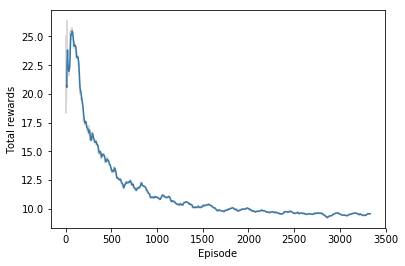

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

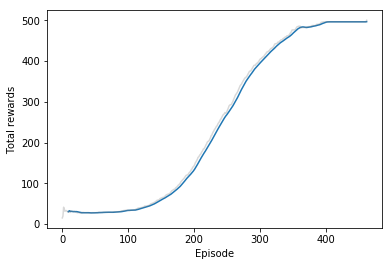

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

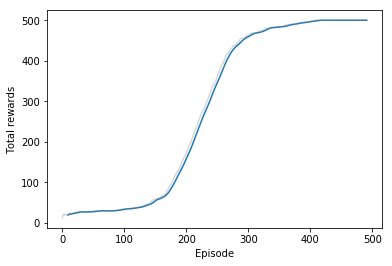

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

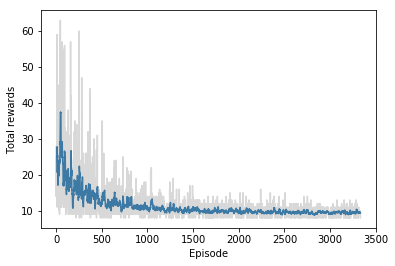

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

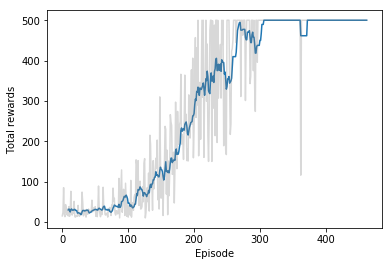

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

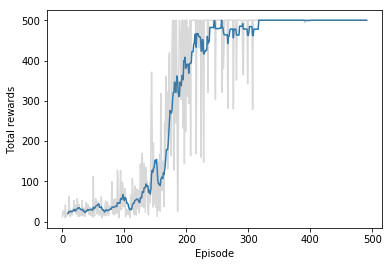

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.